In [19]:
import math
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample')

from datasets.Classification.TwoMoons import create_test_points, create_train_set
from src.network.feature_extractor import FC_Net
from torch import nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from laplace import Laplace
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib

In [20]:
class FC_Net_Laplace(nn.Module):
    def __init__(self, out_dim, weight_decay):
        super().__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, out_dim, bias=False)
        self.nll = nn.LeakyReLU() # dont use normal relu here since otherwise some values can be 0 later
        self.optimizer = torch.optim.Adam(self.parameters(), weight_decay=weight_decay, lr=1e-3)
        self.weight_decay = weight_decay

    def forward(self, x):
        h1 = self.nll(self.fc1(x))
        h2 = self.nll(self.fc2(h1))
        h3 = self.fc3(h2)
        return h3

    def delete_last_layer(self):
        self.forward = self.new_forward
        self.optimizer = torch.optim.Adam(self.parameters(), weight_decay=self.weight_decay, lr=1e-4)

    def new_forward(self, x):
        h1 = self.nll(self.fc1(x))
        h2 = self.nll(self.fc2(h1))
        return h2



In [21]:
# create dataset
n_datapoints = 256
x, y = create_train_set(n_datapoints=n_datapoints, noise=0.2)
batch_size=32
laplace_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size)
n_test_datapoints = 70
X_test, X1_test, X2_test = create_test_points(-2, 3, n_test_datapoints)

In [22]:
# init model
torch.manual_seed(3)
weight_decay = 5e-4
laplace_model = FC_Net_Laplace(2, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

# train
epochs = 200
pbar = tqdm(range(epochs))
for i in pbar:
    for X_batch, y_batch in laplace_loader:
        laplace_model.optimizer.zero_grad()
        loss = criterion(laplace_model(X_batch), y_batch)
        loss.backward()
        laplace_model.optimizer.step()
        pbar.set_description(f"Loss: {round(loss.item(), 2)}")

# define laplace
la = Laplace(laplace_model, "classification",
    subset_of_weights="last_layer", hessian_structure="full",
    prior_precision=5e-4) # prior precision is set to wdecay
la.fit(laplace_loader)



# define weight distribution and update values
from src.weight_distribution.Full import FullCovariance
dist_lp_init = FullCovariance(20, 2, lr=1e-4)
dist_lp_init.update_cov(la.posterior_covariance)
dist_lp_init.update_mean(torch.t(laplace_model.fc3.weight))


# delete last layer
laplace_model.delete_last_layer()


# define VI model
from src.network.Classification import LLVIClassification
from src.network import PredictApprox, LikApprox

prior_log_var=-5
net_lp_init = LLVIClassification(20, 2, laplace_model, dist_lp_init, prior_log_var=prior_log_var, optimizer_type=torch.optim.Adam,
tau=0.001, lr=1e-4)
loss_lp_init = net_lp_init.train_model(laplace_loader, epochs=100, n_datapoints=n_datapoints, method=LikApprox.MONTECARLO, samples=10)


prediction_loss:0.71 kl_loss:15.09: 100%|██████████| 100/100 [00:01<00:00, 74.26it/s]


In [23]:
lr=1e-4
feature_extractor = FC_Net(layers=[2, 20, 20],lr=lr, weight_decay=5e-4, optimizer=torch.optim.Adam, nll=torch.nn.LeakyReLU())
dist = FullCovariance(20, 2, lr=lr)
net = LLVIClassification(20, 2, feature_extractor, dist, prior_log_var=prior_log_var, optimizer_type=torch.optim.Adam,
tau=0.1, lr=lr)
loss = net.train_model(laplace_loader, epochs=100, n_datapoints=n_datapoints, method=LikApprox.MONTECARLO, samples=10)

prediction_loss:0.37 kl_loss:7.53: 100%|██████████| 100/100 [00:01<00:00, 76.41it/s]


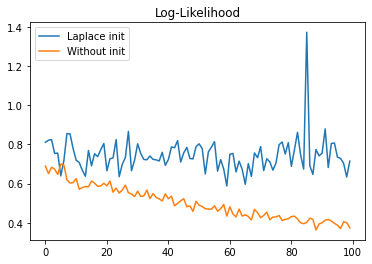

In [24]:
fig, ax = plt.subplots()
ax.plot(range(100), loss_lp_init["prediction_loss"], label="Laplace init")
ax.plot(range(100), loss["prediction_loss"], label="Without init")
ax.legend()
ax.set_title("Log-Likelihood");